# Ture's notebook
Link to competition:<br/>
https://zindi.africa/competitions/traffic-jam-predicting-peoples-movement-into-nairobi<br/>
Other linkes:<br/>
https://www.datacamp.com/community/blog/scikit-learn-cheat-sheet<br/>
Notebooks tip:<br/>
fn+o for toggling cell output between large/small/collapsed
## Import libraries

In [1]:
import time
import io
import random
import datetime as dt
import holidays
from timeit import timeit
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
from pandas import DataFrame
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image
import pydotplus
import scipy
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
from dask.distributed import Client
from sklearn.externals import joblib
from catboost import CatBoostRegressor, cv, Pool
import sqlite3
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import OneHotEncoder, StackingEstimator
from tpot import TPOTRegressor
import seaborn as sns
from featexp import get_univariate_plots, get_trend_stats
from feature_selector import FeatureSelector
import lightgbm as lgb
import featuretools as ft

/Users/tf/miniconda3/envs/nai/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
/Users/tf/miniconda3/envs/nai/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tf/miniconda3/envs/nai/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the Open

## Set global variables
I store all global variables in this cell, as weel as utility functions that I use later on.

In [2]:
InteractiveShell.ast_node_interactivity = "all" # enables multiple cell output
%matplotlib inline
study_start = dt.datetime(2017, 10, 17, 0, 0) # official start
study_end = dt.datetime(2018, 4, 21, 0, 0)    # official end 20.4.2018 + 1 day
study_days = study_end - study_start
seed = 3

# Enable dask backend (gives 5% better training speed)
client = Client(processes=False)

<p/>I brake out repetetive, or chunky code and put it into functions which I gather here at the top of the script:

In [16]:
# Utility functions
def merge_with_uber(df, zuber, offset, prefix=''):
    uber = zuber.copy()
    
    #Prefix
    print('prefix', prefix)
    uber_num_cols = uber.select_dtypes('number').columns.values.tolist()
    prefixed = [prefix + col_name for col_name in uber_num_cols]
    uber.rename(columns=dict(zip(uber_num_cols, prefixed)), inplace=True)
    uber_num_cols = prefixed
    
    # Add join colums to df
    df['travel_datetime'] = df.travel_date + pd.TimedeltaIndex(df.travel_time, unit='m')
    df['outskirts_dt'] = df.travel_datetime + dt.timedelta(hours=offset)
    df['outskirts_d'] = df.outskirts_dt.dt.normalize()

    me = pd.merge(df, uber, how='left', left_on='outskirts_d', right_on='Date')
    print('Shape after merger:', me.shape)
    print('Null dates in range:', me[me.Date.isnull()].outskirts_d.dt.date.min(), '–', me[me.Date.isnull()].outskirts_d.dt.date.max())

    # Plugging av NaN values
    me[uber_num_cols] = me[uber_num_cols].fillna(value=0)
    #me.dropna(subset=uber_num_cols, inplace=True)
    #me[uber_num_cols] = me[uber_num_cols].interpolate(method='linear')
    print('Columns with null values:')
    nan_stats = me.isnull().sum(axis=0)
    nan_stats[nan_stats != 0]
    
    # Remove join columns
    me.drop(columns=['travel_datetime', 'outskirts_dt', 'outskirts_d', 'Date'], inplace=True)
    uber_features = uber.columns.difference(['Date']).values.tolist()
    return me, uber_features


def merge_with_uber_period(df, zuber_period, offset, prefix=''):
    uber_period = zuber_period.copy()
    
    # Prefix
    uber_num_cols = uber_period.select_dtypes('number').columns.values.tolist()
    prefixed = [prefix + col_name for col_name in uber_num_cols]
    uber_period.rename(columns=dict(zip(uber_num_cols, prefixed)), inplace=True)
    uber_num_cols = prefixed
    
    # Add join colums to df
    df['travel_datetime'] = df.travel_date + pd.TimedeltaIndex(df.travel_time, unit='m')
    df['outskirts_dt'] = df.travel_datetime + dt.timedelta(hours=offset)
    df['outskirts_d'] = df.outskirts_dt.dt.normalize()
    
    conn = sqlite3.connect(':memory:')
    conn.text_factory = str
    df.to_sql('df', conn, index=False)
    uber_period.to_sql('uber_period', conn, index=False)
    sql = '''
        SELECT d.*, u.*
        FROM df d
        LEFT OUTER JOIN uber_period u
        ON d.outskirts_dt >= u.fromm and d.outskirts_dt < u.too
        '''
    me2 = pd.read_sql_query(sql, conn)
    conn.close()
    print('Shape after merger2:', me2.shape)

    # Plugging av NaN values
    me2[uber_num_cols] = me2[uber_num_cols].fillna(value=0)
    print('Columns with null values:')
    nan_stats = me2.isnull().sum(axis=0)
    nan_stats[nan_stats != 0]
    
    # Remove join columns
    me2.drop(columns=['travel_datetime', 'outskirts_dt', 'outskirts_d', 'fromm', 'too'], inplace=True)
    period_features = uber_period.columns.difference(['fromm', 'too']).values.tolist()
    
    return me2, period_features


def grid_search(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error'
                               , n_jobs=-1, refit=False, verbose=True)
    start = time.time()
    with joblib.parallel_backend('dask'):
        grid_search.fit(X,y)
    elapsed = int(round(time.time() - start))
    print('grid seach tok %ds' % elapsed)
    print('best_params_', grid_search.best_params_)
        
        
def evaluate(model, verbose=True, fit_params=None):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    if verbose: 
        print('Mae:', round(mae, 4))
        
    print('Cross-validating...')
    if fit_params and 'eval_set' in fit_params:
        # hold out X_test  
        X_cv = X_train
        y_cv = y_train
    else:
        X_cv = X
        y_cv = y
    with joblib.parallel_backend('dask'):
        scores = cross_val_score(model, X=X_cv, y=y_cv, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, fit_params=fit_params)
    
    if verbose: 
        print('Scores:', scores.round(4))
        print('Mean:', round(abs(scores.mean()), 4))
        print('Standard deviation:', round(scores.std(), 4))
    print('|  |', round(mae, 2), '|', round(abs(scores.mean()), 2), '|', round(scores.std(), 2), '| - |')

## Read source files
We need to read in the data fies proviced in CSV format, and data files we have extracted from Uber Movement and preprocess in a seperate Jupiter notebook called [uber.ipnb](http://localhost:8888/notebooks/uber.ipynb). They are in in pickle format.<p/>
We found many holes in uber Movment Nairobi data, especially further away from the centre. We decided therefore to only use data from 1 shorter, centrally located section, Hinga Rd to Muthithi Rd. We compared this to another section, Westland to AfyaCentre, but finnally concluded that the second section did not any more value.

In [4]:
# Read files
train_revised = pd.read_csv('train_revised.csv')
test_questions = pd.read_csv('test_questions.csv')
uber = pd.read_pickle('uber_hingard.pkl') # from Hinga Rd to Muthithi Rd
uber_period = pd.read_pickle('uber_hingard_periods.pkl') # from Hinga Rd to Muthithi Rd
uber2 = pd.read_pickle('uber_westland.pkl') # from Westland to Afya Centre
uber_period2 = pd.read_pickle('uber_westland_periods.pkl') # from Westland to Afya Centre

# Drop columns
train_revised.drop(columns=['seat_number', 'payment_method', 'payment_receipt', 'travel_to'], inplace=True)
test_questions.drop(columns=['travel_to'], inplace=True)
uber.drop(columns=['Origin Display Name', 'year', 'quarter', 'Month', 'doy', 'Holiday', 'Rainfall'], inplace=True)
uber2.drop(columns=['Origin Display Name', 'year', 'quarter', 'Month', 'doy'], inplace=True)

# Print
print('train_revised', train_revised.shape)
print('test_questions', test_questions.shape)
print('uber', uber.shape, uber.Date.dt.date.min(), '–', uber.Date.dt.date.max())
print('uber period', uber_period.shape, uber_period.fromm.dt.date.min(), '–', uber_period.too.dt.date.max())

train_revised (51645, 6)
test_questions (1111, 6)
uber (730, 19) 2016-06-30 – 2018-06-29
uber period (3521, 5) 2016-06-30 – 2018-06-30


## Aggregate number of tickets

The provided data comes in form of ticket sales transactions. 
We are assigned to learn and predict number of passagers pr trip. 
So we need to aggregated the provided data to a per-trip level.

In [5]:
agg = train_revised.groupby(by=['ride_id', 'travel_date', 'travel_time', 'travel_from', 'car_type', 'max_capacity'], as_index=False).size().reset_index(name='number_of_ticket')
print('agg', agg.shape)

#There should be no duplicates in test_questions....
no_dubs = test_questions[test_questions.duplicated(['ride_id', 'travel_date', 'travel_time', 'travel_from', 'car_type', 'max_capacity'], keep=False)].size
print('duplicates in test_questions:', no_dubs)

agg (6249, 7)
duplicates in test_questions: 0


## Convert datatypes
Some of the columns in the cvs files are coming as strings and need to be converted to the proper datatype (datetime, Categorical).

In [6]:
#Convert datatypes
all = pd.concat([agg, test_questions], sort=False)
all['travel_date'] = pd.to_datetime(all.travel_date, infer_datetime_format=True)
print('travel_date:', all.travel_date.dt.date.min(), '–', all.travel_date.dt.date.max())
all['travel_time'] = pd.to_datetime(all['travel_time'], format='%H:%M').dt.time

cat_cars = ['Bus', 'shuttle']
all['car_type'] = pd.Categorical(all['car_type'], ordered=True, categories=cat_cars)

cat_cities = ['Migori', 'Keroka', 'Homa Bay', 'Kisii', 'Keumbu', 'Rongo', 'Kijauri', 'Oyugis', 'Awendo', 'Sirare', 'Nyachenge', 'Kehancha', 'Kendu Bay', 'Sori', 'Rodi', 'Mbita', 'Ndhiwa']
cat_cities = random.Random(seed).shuffle(cat_cities)
all['travel_from'] = pd.Categorical(all['travel_from'], ordered=True, categories=cat_cities)

print(all.head(2).T)

travel_date: 2017-01-12 – 2018-12-04
                                    0                    1
ride_id                          1442                 5437
travel_date       2017-10-17 00:00:00  2017-11-19 00:00:00
travel_time                  07:15:00             07:12:00
travel_from                    Migori               Migori
car_type                          Bus                  Bus
max_capacity                       49                   49
number_of_ticket                    1                    1


## Feature engineering
We tested out a couple of features that we ended up not using. You find them commented out.
Combined the categorical features into new "cross" features tunred out fruitful.

In [7]:
eng = all.copy()
eng['hour'] =  pd.to_datetime(eng.travel_time.astype(str)).dt.hour
eng['travel_time'] = pd.to_datetime(eng.travel_time.astype(str)).dt.minute + eng.hour * 60
eng['month'] = eng.travel_date.dt.month #January=1, December=12
#eng['day'] = eng.travel_date.dt.day
eng['weekday'] = eng.travel_date.dt.weekday #Monday=0, Sunday=6
eng['weekend'] = eng.weekday.isin([5, 6]).astype(int)
#eng['travel_date_ord'] = eng.travel_date.dt.strftime('%Y%m%d').astype(int)
eng['diy'] = eng.travel_date.dt.dayofyear
#eng['dihy'] = eng.travel_date.dt.dayofyear % 182
#eng.head()

# Encoding
#car_encoder = LabelEncoder().fit(eng.car_type)
#eng['car_type'] = car_encoder.transform(eng.car_type)
eng['car_type'] = eng.car_type.cat.codes

#city_encoder = LabelEncoder().fit(eng.travel_from)
#eng['travel_from'] = city_encoder.transform(eng.travel_from) 
eng['travel_from'] = eng.travel_from.cat.codes

# Post-encoding features
eng['travel_from_hour'] = eng.travel_from.astype(int) * 100 + eng.hour
eng['travel_from_hour'] = eng.travel_from_hour.rank(method='min').astype(int)

eng['travel_from_wd_h'] = eng.travel_from.astype(int) * 1000 + (eng.weekday + 1) * 100 + eng.hour
eng['travel_from_wd_h'] = eng.travel_from_wd_h.rank(method='min').astype(int)

#eng['travel_from_h_wd'] = eng.travel_from.astype(int) * 1000 + eng.hour * 10 + eng.weekday
#eng['travel_from_h_wd'] = eng.travel_from_h_wd.rank(method='min').astype(int)

In [8]:
# Merge in uber data
me, uber_features = merge_with_uber(eng, uber, offset=8.5, prefix='')
me2, period_features = merge_with_uber_period(me, uber_period, offset=8.5, prefix='')
me2['travel_date'] = pd.to_datetime(me2.travel_date) # a fix
m3, uber_features2 = merge_with_uber(me2, uber2, offset=10.5, prefix='w_')
me2, period_features2 = merge_with_uber_period(m3, uber_period2, offset=10.5, prefix='w_')
#me['midday lower'] = np.log(me['midday lower'])
#me['evening lower'] = np.log(me['evening lower'])

print(me2.head(3).T)

prefix 
Shape after merger: (7360, 36)
Null dates in range: 2018-07-01 – 2018-12-05
Columns with null values:


/Users/tf/miniconda3/envs/nai/lib/python3.6/site-packages/pandas/core/generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


Shape after merger2: (7360, 40)
Columns with null values:
prefix w_
Shape after merger: (7360, 57)
Null dates in range: 2018-07-01 – 2018-12-05
Columns with null values:
Shape after merger2: (7360, 61)
Columns with null values:
                                    0                    1  \
ride_id                          1442                 5437   
travel_date       2017-10-17 00:00:00  2017-11-19 00:00:00   
travel_time                       435                  432   
travel_from                         9                    9   
car_type                            0                    0   
max_capacity                       49                   49   
number_of_ticket                    1                    1   
hour                                7                    7   
month                              10                   11   
weekday                             1                    6   
weekend                             0                    1   
diy                         

## PCA
We testet out if encoding the uber columns as 4 PCA components would yield better results that using a couple of individual uber columns directly. Turned out using the two uber columns 'midday lower' and 'evening lower' gave the best result. Consequentluy we added the PCA columns to the scipcols list. 

In [9]:
# PCA
data2 = me2[uber_features2 + period_features2]
pca = PCA(n_components=4)
components = DataFrame(pca.fit_transform(data2), columns=['pca1', 'pca2', 'pca3', 'pca4'])
me3 = pd.concat([me2, components], axis=1, sort=False)

## Labeling
In this cell we defined which column contains the lable, which columns are of categorical nature (for use in CatBoost) and which columns to ignore during training (skipcols).

In [12]:
# Labeling
label = 'number_of_ticket'
scipuber = np.setdiff1d(uber_features, ['midday lower', 'evening lower']).tolist()
scipuberperiod2 = np.setdiff1d(period_features2, []).tolist()
skipcols = [label, 'ride_id', 'travel_date', 'Date', 'travel_datetime', 'outskirts_dt', 'outskirts_d'
            , 'hour', 'fromm', 'too', 'lower', 'upper', 'mean'
            , 'pca1', 'pca2', 'pca3', 'pca4'
            , 'car_type', 'month', 'weekend'
           ] + scipuber + period_features + uber_features2 + scipuberperiod2
categorical = ['car_type', 'travel_from', 'travel_from_hour', 'travel_from_wd_h']
categorical = np.setdiff1d(categorical, skipcols).tolist()

## Featuretools
We decided to give the Featuretools framework a try. <br/>
You find it here: https://www.featuretools.com<br/>
Featuretools i s a open source framework for automatic feature generation.<br/>
It looks promising for the multi source tables -case (with typically multiple 1–many relationships) but for the one source table case as in this case, it turned out to be useless. Did not generate any new features... 

In [11]:
### Featuretools
good = me3[me3.columns.difference(np.setdiff1d(skipcols, ['ride_id']).tolist())]
print('Number of features before:', good.shape[1])
es = ft.EntitySet()
es.entity_from_dataframe('good', good, index='ride_id')
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='good')
print('Number of featrues after', feature_matrix.shape[1])

Number of features before: 10


Entityset: None
  Entities:
    good [Rows: 7360, Columns: 10]
  Relationships:
    No relationships

Number of featrues after 9


In [13]:
# Role your own...
for feat in ['hour', 'weekday', 'travel_from']:
    me3[feat + '_mean'] = me3.groupby(by=[feat])[label].transform(lambda x: x.mean())
    #me3[feat + '_std'] = me3.groupby(by=[feat])[label].transform(lambda x: x.std()).fillna(0.0)
    #me3[feat + '_min'] = me3.groupby(by=[feat])[label].transform(lambda x: x.min())
    #me3[feat + '_max'] = me3.groupby(by=[feat])[label].transform(lambda x: x.max())
    #me3[feat + '_mode'] = me3.groupby(by=[feat])[label].transform(lambda x: x.dropna().mode()[0])

print('Columns with null values:')
nan_stats = me3.isnull().sum(axis=0)
nan_stats[nan_stats != 0]

Columns with null values:


number_of_ticket    1111
dtype: int64

## Cutting & Splitting

In [14]:
# Cutting
#eng = eng[((eng.travel_date >= study_start) & (eng.travel_date < study_end)) | (eng[label].isnull())]
#eng = eng[(eng.travel_date < study_end) | (eng[label].isnull())]
#print('Test question period', eng[eng[label].isnull()].travel_date.min(), '–', eng[eng[label].isnull()].travel_date.max())
#eng = eng[(eng.travel_date < study_end) | (eng[label].isnull()) | (eng.travel_date > dt.datetime(2018, 5, 9, 0, 0))]
clean = me3[me3.columns.difference(skipcols)]
print(clean.shape)
print(clean.describe().T.drop(columns=['count', '25%', '50%', '75%']))

# Splitting
df_ml, df_quest = me3[me3[label].notnull()], me3[me3[label].isnull()] 
X, y = df_ml[df_ml.columns.difference(skipcols)], df_ml[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
Xy_train = pd.concat([X_train, y_train], axis=1, sort=False)
Xy_test = pd.concat([X_test, y_test], axis=1, sort=False)
Xy = pd.concat([X, y], axis=1, sort=False)

(7360, 12)
                         mean          std         min          max
diy                151.990489   113.535922    1.000000   365.000000
evening lower      472.331793   221.060634    0.000000   933.000000
hour_mean            8.271910     2.809307    3.042169    19.417778
max_capacity        30.557609    18.993106   11.000000    49.000000
midday lower       576.919429   268.280446    0.000000   930.000000
travel_from          7.522418     3.697972    0.000000    16.000000
travel_from_hour  3456.360326  2092.183561    1.000000  7348.000000
travel_from_mean     8.276662     5.067687    1.000000    23.293194
travel_from_wd_h  3647.781114  2120.619544    1.000000  7358.000000
travel_time        506.450815   197.570207  300.000000  1392.000000
weekday              2.887228     1.958407    0.000000     6.000000
weekday_mean         8.264409     0.072595    8.164900     8.374239


## Average model
We decided to take the average number_of_ticket as a first benchmark that our machine learing models needed to surpase. We calculated a MAE (=mean absolute error) of 6.<p/>
Then we tought that an average measure like this would be quite inadequate given the two very different types of vehicles taking 11 or 49 passangers. So we calculated a second measure that would take average values on their appropriate classes. Interstingly enough, the MAE score became worse, at 6,22.<p/>

In [119]:
mean = y_train.mean()
y_pred0 = pd.Series(data=[mean] * y_test.shape[0], name='y_pred0')
mae = mean_absolute_error(y_pred0, y_test)
print('Average 1:', round(mean, 4), ', Mae 1:', round(mae, 4))

# Average training2
buss_mean = Xy_train[Xy_train.max_capacity==49].number_of_ticket.mean()
shuttle_mean = Xy_train[Xy_train.max_capacity==11].number_of_ticket.mean()
y_pred = X_test.max_capacity.apply(lambda x: buss_mean if x==49.0 else shuttle_mean)
mae = mean_absolute_error(y_pred, y_test)
print('Average 2:', round(buss_mean, 4), '/', round(shuttle_mean, 4), ', Mae 2:', round(mae, 4))

#Visualize the distributions.
#Z = Xy_test[['max_capacity', 'number_of_ticket']].copy()
#Z = pd.concat([Z, y_pred.to_frame(name='y_pred')], axis=1)
#Z['diff'] = abs(Z.number_of_ticket - Z.y_pred)
#Z.reset_index(drop=True, inplace=True)
#Z = pd.concat([Z, y_pred0], axis=1)
#Z['diff0'] = abs(Z.number_of_ticket - Z.y_pred0)
#print('Control calc', Z['diff'].mean(), Z['diff0'].mean())
#ax = Xy_train[Xy_train.max_capacity==49].number_of_ticket.hist(bins=25, alpha=0.5)
#Xy_train[Xy_train.max_capacity==11].number_of_ticket.hist(bins=10, ax=ax, alpha=0.5, color='red');

Average_1: 8.2561 , Mae_1: 6.0038
Average2: 9.9925 / 6.4508 , Mae_2: 6.2201


## Linear Regression
We decided to run a series of different ML models and kicked it of with a scikit learn's LinearRegression model. 

In [121]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
print('Mae:', round(mae, 4))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Mae: 4.662


## Decision Trees
Decision trees gave good initial results and we spent some time with it.<br/>
We prepended the training cell with a cell for hyperparamter-tuning.
So we could easily refit the model when number of features changed.

In [31]:
# Hyperparameter-tuning
tree2 = DecisionTreeRegressor(random_state=seed, criterion='mae')

In [33]:
param_grid = [{'max_depth': [6, 7, 8], 'max_features': [10, 11, 12], 'min_samples_split': [6, 7, 8]}]
grid_search = GridSearchCV(tree2, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, refit=False, verbose=True)
start = time.time()
with joblib.parallel_backend('dask'):
    grid_search.fit(X,y)
print('grid seach tok %.0fs' % (time.time() - start))
print('best_params_', grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   33.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=3, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [6, 7, 8], 'max_features': [10, 11, 12], 'min_samples_split': [6, 7, 8]}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=True)

grid seach tok 33s
best_params_ {'max_depth': 6, 'max_features': 10, 'min_samples_split': 8}


In [ ]:
# Train tree
tree = DecisionTreeRegressor(random_state=seed, criterion='mae', max_depth=7, max_features=8, min_samples_leaf=7)
tree.fit(X_train, y_train)

In [30]:
# Evaluate
y_pred = tree.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
print('Mae:', round(mae, 4))

print('Cross-validating...')
with joblib.parallel_backend('dask'):
    scores = cross_val_score(tree, X=X, y=y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print('Mean:', round(abs(scores.mean()), 4))
print('Standard deviation:', round(scores.std(), 4))

Mae: 3.7516
Cross-validating...
Mean: 4.0679
Standard deviation: 0.3503


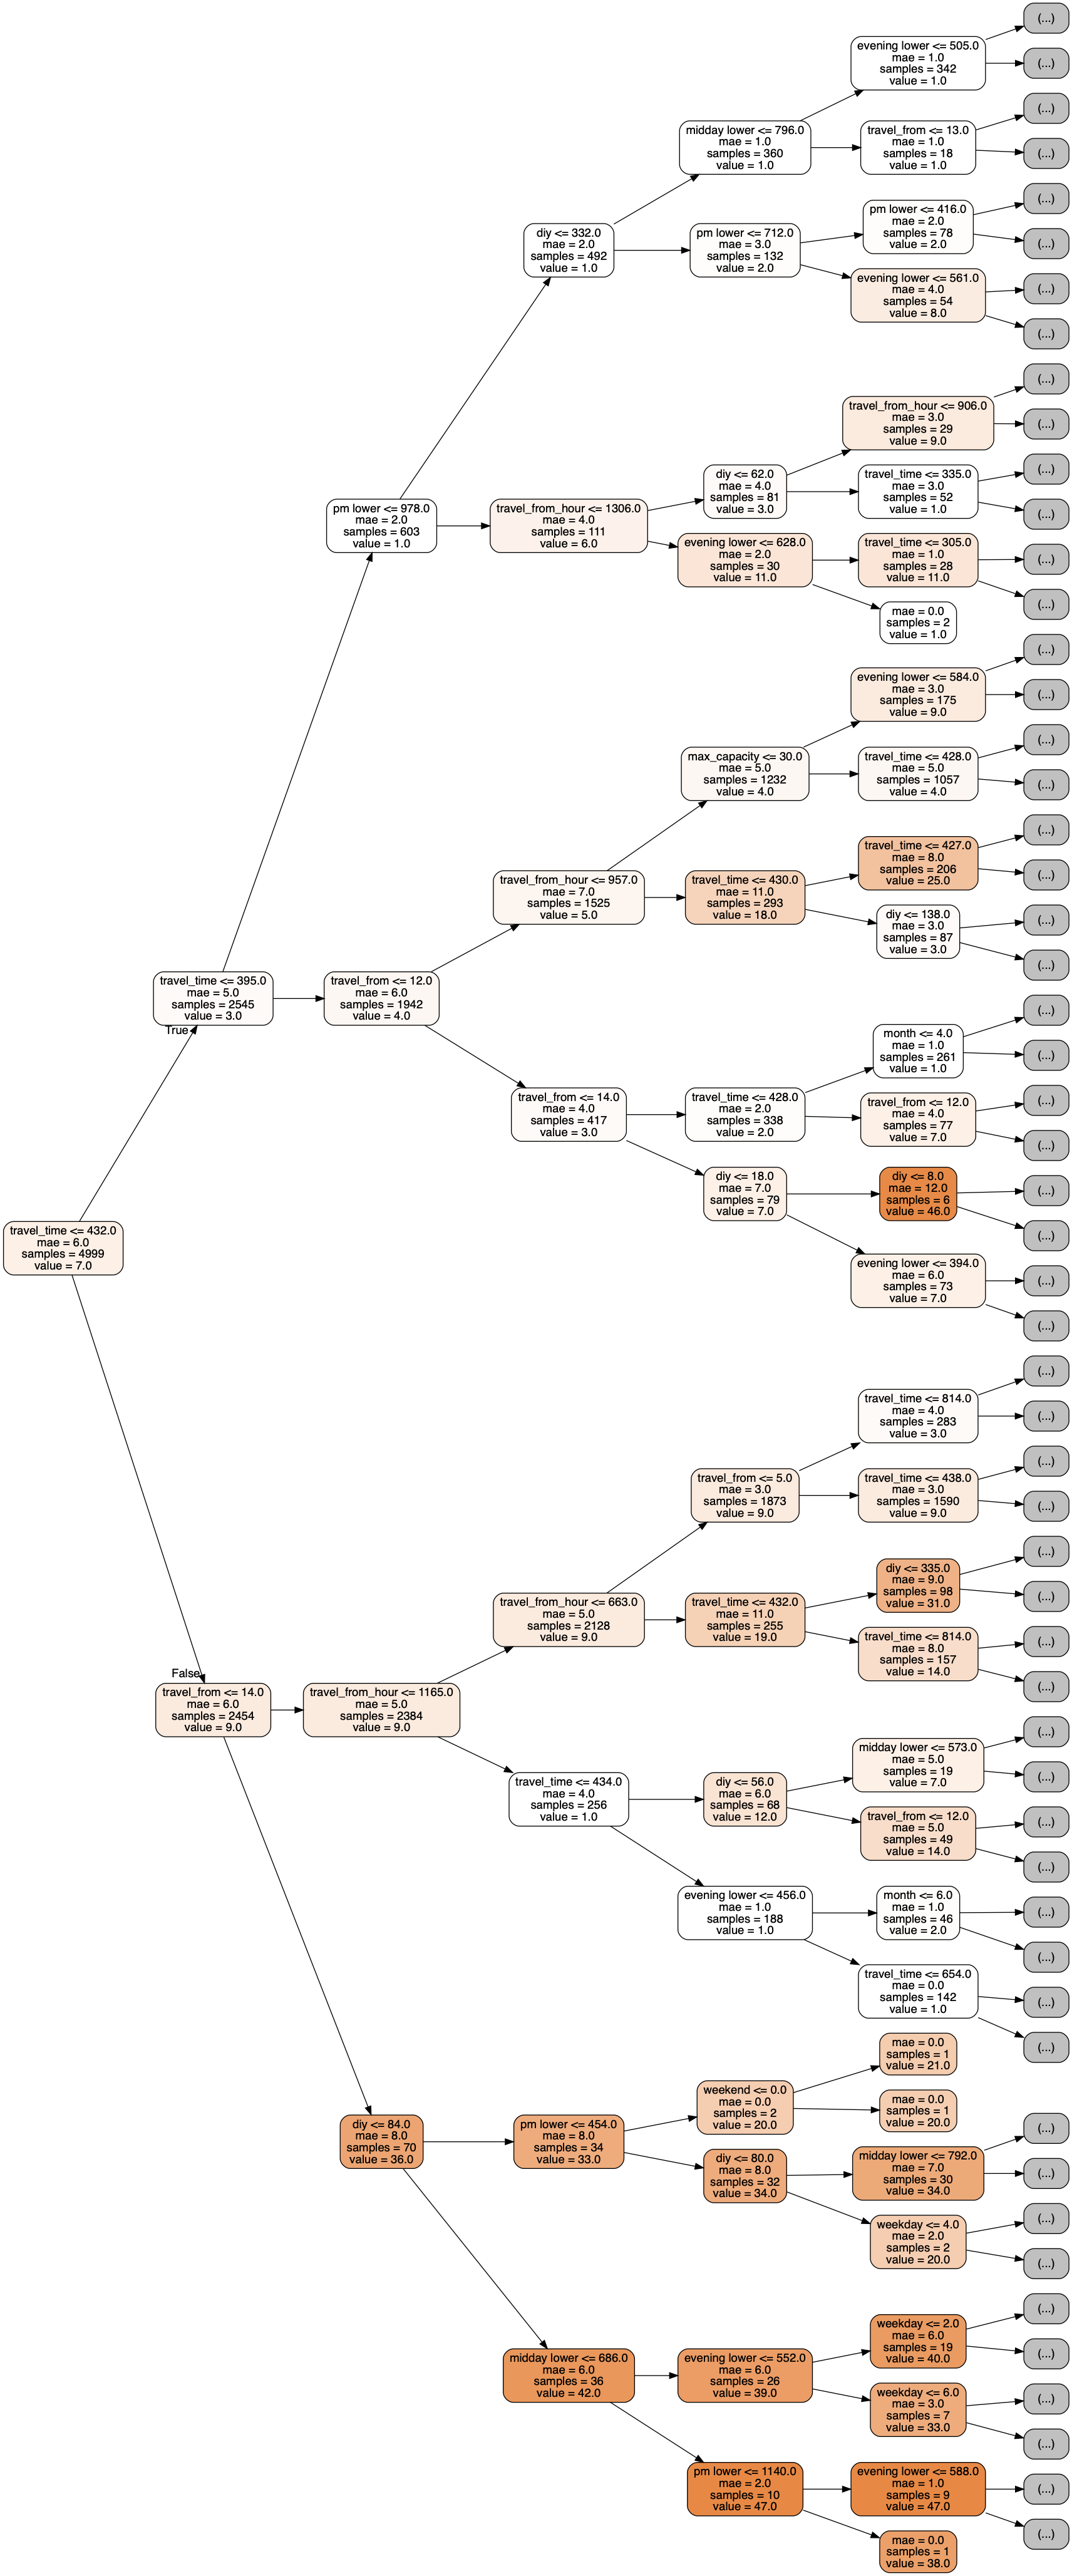

In [21]:
# Visualize tree
dot_data = io.StringIO()
export_graphviz(tree, filled=True, rounded=True, out_file=dot_data, feature_names=X.columns, rotate=True, max_depth=5, precision=0)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Random forest
Random forest eventually turned out to be the most promissing ML algorithm.<br/>
Seemed to be less prone to overfitting.<p/>
We preceed the training cell with a hyperparameter tuning cell.
To be able to quickly adjust parameters to a new set of feature columns, this is.
We do a grid search for the best parameters, it is moved out into a function grid_search() and used at several of the other models as well.


In [145]:
# Hyperparameter-tuning
# optimal 910200
forest2 = RandomForestRegressor(criterion='mae', random_state=seed, n_estimators=10)
param_grid = [{'max_depth': [9, 10, 11, 12], 'max_features': [8 ,9 ,10]}]
grid_search(forest2, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s


grid seach tok 58s
best_params_ {'max_depth': 9, 'max_features': 9}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   58.1s finished


In [18]:
# Training
forest = RandomForestRegressor(random_state=seed, criterion='mae'
    , max_depth=9, n_estimators=200, n_jobs=-1, warm_start=False
, max_features=9
)

s = time.time()

with joblib.parallel_backend('dask'):
    forest.fit(X_train, y_train)
evaluate(forest)

e = time.time() - s
print('Execution tok:%.0fs' % round(e))

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=9,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=3,
           verbose=0, warm_start=False)

Mae: 3.5993
Cross-validating...
Scores: [-3.6317 -4.0981 -3.5374 -3.8773 -4.1896]
Mean: 3.8668
Standard deviation: 0.2536
|  | 3.6 | 3.87 | 0.25 | - |
Execution tok:118s


## LightGBM

In [177]:
# Hyperparameter-tuning
# best: {'learning_rate': 0.075, 'min_child_samples': 20, 'n_estimators': 55, 'num_leaves': 31}
gbm2 = lgb.LGBMRegressor(random_state=seed, n_jobs=-1)
param_grid = [{'learning_rate': [0.074, 0.075, 0.76],'min_child_samples': [19, 20, 21]
               ,'n_estimators': [54,55, 56],'num_leaves': [30, 31, 32],}]
grid_search(gbm2, param_grid)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min


grid seach tok 227s
best_params_ {'learning_rate': 0.075, 'min_child_samples': 20, 'n_estimators': 55, 'num_leaves': 31}


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  3.8min finished


In [198]:
# Training
gbm = lgb.LGBMRegressor(random_state=seed, n_jobs=-1
    , learning_rate=0.075, min_child_samples=20, n_estimators=55, num_leaves=31
)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', verbose=False
    #, early_stopping_rounds=10
    , categorical_feature=categorical
)

#evaluate(model=gbm, fit_params={'eval_set': [(X_test, y_test)], 'early_stopping_rounds': 10, 'verbose': False})
evaluate(model=gbm)

/Users/tf/miniconda3/envs/nai/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['car_type', 'travel_from', 'travel_from_hour', 'travel_from_wd_h']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.075, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=55, n_jobs=-1, num_leaves=31, objective=None,
       random_state=3, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Mae: 3.83
Cross-validating...
Scores: [-3.809  -4.3762 -3.8801 -4.0817 -4.6296]
Mean: 4.1553
Standard deviation: 0.3082
|  | 3.83 | 4.16 | 0.31 | - |


## CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 397
Mae: 3.7419
Parameters: {'bagging_temperature': 0.2, 'eval_metric': 'MAE', 'verbose': 0, 'random_seed': 3, 'od_type': 'Iter', 'loss_function': 'MAE', 'depth': 4, 'learning_rate': 0.6, 'iterations': 400}
Feature importance:


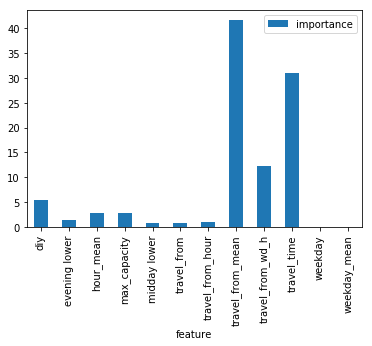

In [24]:
# Training
cat = CatBoostRegressor(
    #loss_function='MAE', random_seed=seed, logging_level='Silent')
    iterations=400, learning_rate=0.6, depth=4, loss_function='MAE', random_seed=seed,
    #use_best_model=True, 
    od_type='Iter',
    eval_metric='MAE',
    bagging_temperature = 0.2,
    verbose=0)

cat_features = X_train.columns.isin(['car_type', 'travel_from', 'travel_from_hour']).nonzero()[0]
cat.fit(X_train, y_train
    , cat_features=cat_features
    , eval_set=(X_test, y_test)
    , use_best_model=True
    , plot=True)

print('Best iteration:', cat.get_best_iteration())
y_pred = cat.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
print('Mae:', round(mae, 4))

# Running a cross-validation
pool = Pool(X_train, y_train)
params = cat.get_params()
print('Parameters:', params)
cv(pool=pool, params=params, fold_count=5, partition_random_seed=seed)

# Pull out feature importance
print('Feature importance:')
feature_importance = pd.DataFrame(list(zip(X_train.columns,cat.get_feature_importance())), columns=['feature', 'importance'])
feature_importance.plot(kind='bar',x='feature');

## Scatter plot

In [37]:
y_cols = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df = pd.concat([X_test, y_cols], axis=1, sort=False)
ax = df[df.car_type==0].plot(x='y_test', y='y_pred', kind='scatter', xlim=[0,50]
                             , ylim=[0,50], color='red', label='bus', alpha=0.2)
ax = df[df.car_type==1].plot(x='y_test', y='y_pred', kind='scatter', xlim=[0,50]
                             , ylim=[0,50], color='blue', label='shuttle', ax=ax, alpha=0.1)
ax.plot([0,50], [0,50], ls="--", c=".3")

AttributeError: 'DataFrame' object has no attribute 'car_type'

## Feature Importance

,importance
feature,
travel_from_mean,0.416650
travel_time,0.244855
travel_from_hour,0.105640
diy,0.069064
travel_from_wd_h,0.041135
midday lower,0.030453
month_mean,0.027574
evening lower,0.025082
max_capacity,0.012008


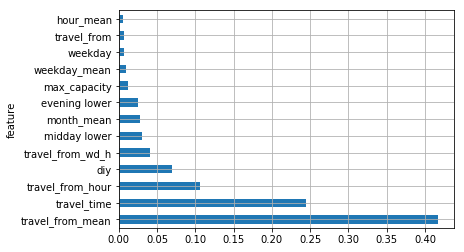

In [123]:
model = forest
imp = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
imp.set_index('feature', drop=True, inplace=True)
imp.sort_values(by='importance', ascending=False, inplace=True)
imp
imp.plot(kind='barh', legend=False, grid=True)

Travel_from and various features derived from that had the highest feature importance.<p/>

We decided to test out the [eli5](https://eli5.readthedocs.io/en/latest/index.html) framework.
Permutation importance is an altewrnative feature importance measure. Basically, if a features values get scrambled up, how much does this deteriorate the prediction accurracy.<br/>
    

In [124]:
# Permutation importance
import eli5
model = forest
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.values.tolist(), top=50)

Weight,Feature
0.7030 ± 0.0729,travel_from_mean
0.2349 ± 0.0267,travel_time
0.1373 ± 0.0038,travel_from_hour
0.0406 ± 0.0212,diy
0.0255 ± 0.0105,travel_from_wd_h
0.0091 ± 0.0059,month_mean
0.0048 ± 0.0041,midday lower
0.0023 ± 0.0094,max_capacity
0.0021 ± 0.0024,travel_from
0.0010 ± 0.0057,evening lower


A *dentrogram* can be used to highlight the most redundant features – candidates for being cut away.<br/>
It is a kind of hierarchical clustering. The sooner two features collide into each other, the more correlated they are. The idea for using this comes from [My first kaggle competition using random forests to predict housing prices](https://towardsdatascience.com/my-first-kaggle-competition-using-random-forests-to-predict-housing-prices-76efee28d42f)

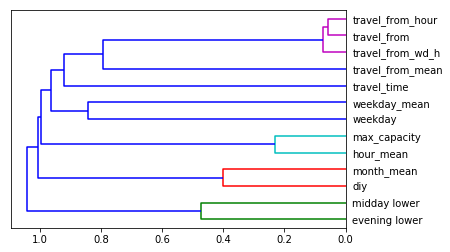

In [125]:
# Dendrogram
corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
dendrogram = hc.dendrogram(z, labels=X.columns, orientation='left', leaf_font_size=10)

We found that feature importance pluss correlation, is the ultimate measure for evaluating features!<p/>
For a correlation matrix we first used the simple pandas version, and then a more beautiful version of the seaborn library.<br/>

In [ ]:
#Ugly pandas matrix:
#corr.style.background_gradient().set_precision(1)

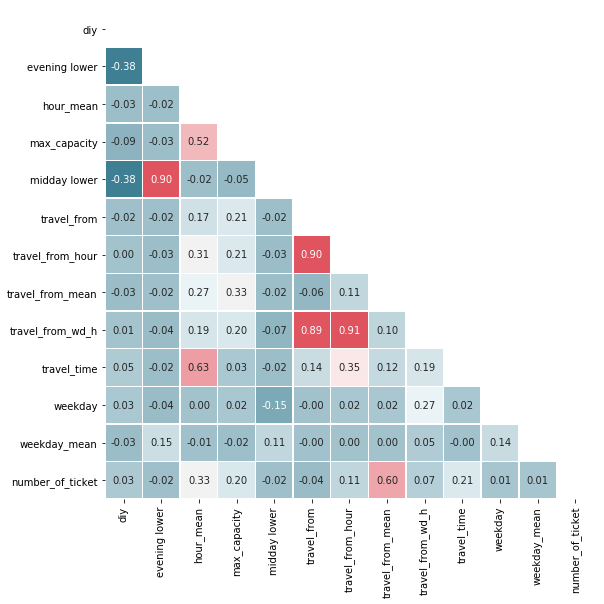

In [35]:
# Correlations
corr = Xy_train.corr()

# Beautiful seaborn matrix:
mask = np.zeros_like(corr, dtype=np.bool);
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(9,9));
sns.heatmap(corr, xticklabels=corr.columns.values
            , yticklabels=corr.columns.values, annot=True
            , cbar=False, ax=ax, linewidths=.5, square=True
            , mask=mask, cmap=cmap, fmt='.2f');

Correlation matrix is essential when multiple features are highly correlated with each other. In many cases it is sufficient to look only at the strongest correlated co-feature for each feature. They are called **colinear features** and can be displayed in a table like this:

In [36]:
# Colinear features table
arr = corr.values
np.fill_diagonal(arr, None)
corr = DataFrame(arr, columns=corr.columns, index=corr.index)
abs_corr = abs(corr)
max_corr_cols = abs_corr.idxmax(axis=1)
max_corr_cols.name = 'feature2'
max_corr = abs_corr.max(axis=1)
max_corr.name = 'cor'
corr_df = pd.concat([max_corr, max_corr_cols], axis=1).reset_index()
corr_df.set_index('index', inplace=True)
corr_df.index.name='feature'
corr_df.sort_values('cor', ascending=False, inplace=True)
corr_df.style.set_precision(2)

,cor,feature2
feature,,
travel_from_hour,0.91,travel_from_wd_h
travel_from_wd_h,0.91,travel_from_hour
evening lower,0.9,midday lower
midday lower,0.9,evening lower
travel_from,0.9,travel_from_hour
hour_mean,0.63,travel_time
travel_time,0.63,hour_mean
travel_from_mean,0.6,number_of_ticket
number_of_ticket,0.6,travel_from_mean


As a sublemental indicator for feature importance we used **noisiness** and **trend correlation**, as suggested in the article <br/>"[My secret sauce to be in top 2 of a kaggle competition](https://towardsdatascience.com/my-secret-sauce-to-be-in-top-2-of-a-kaggle-competition-57cff0677d3c)". <br/>
The basic idea: Features where the trend on the test-set compared to training-set shifts direction a lot, are bad. <br/>
We tok inspiration from this but did not tread this as an absolute criterion. We added up including some features with weak trend correlation nevertheless. Maybe the section-wize working principle of decision trees counterbalanced the negative effect or something like that...? 

Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,diy,4,7,0.487838
1,evening lower,6,3,0.477684
2,max_capacity,0,0,1.000000
3,midday lower,5,8,0.520547
4,travel_from,2,2,0.982108
5,travel_from_hour,3,3,0.980470
6,travel_from_wd_h,4,4,0.977106
7,travel_time,4,4,0.990044
8,weekday,3,3,-0.895048


                                            Plots for diy                                             
                                           Train data plots                                           


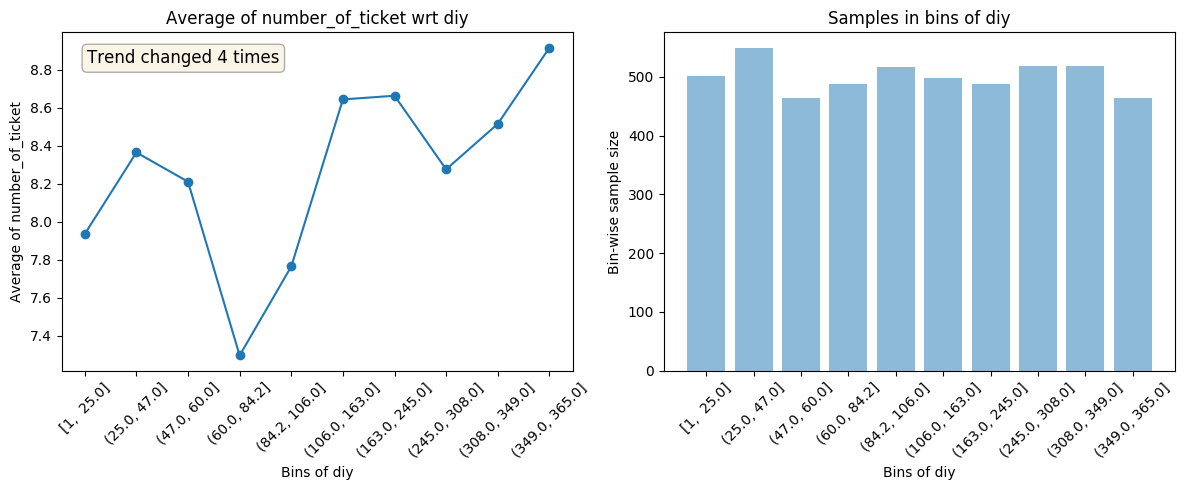

                                           Test data plots                                            


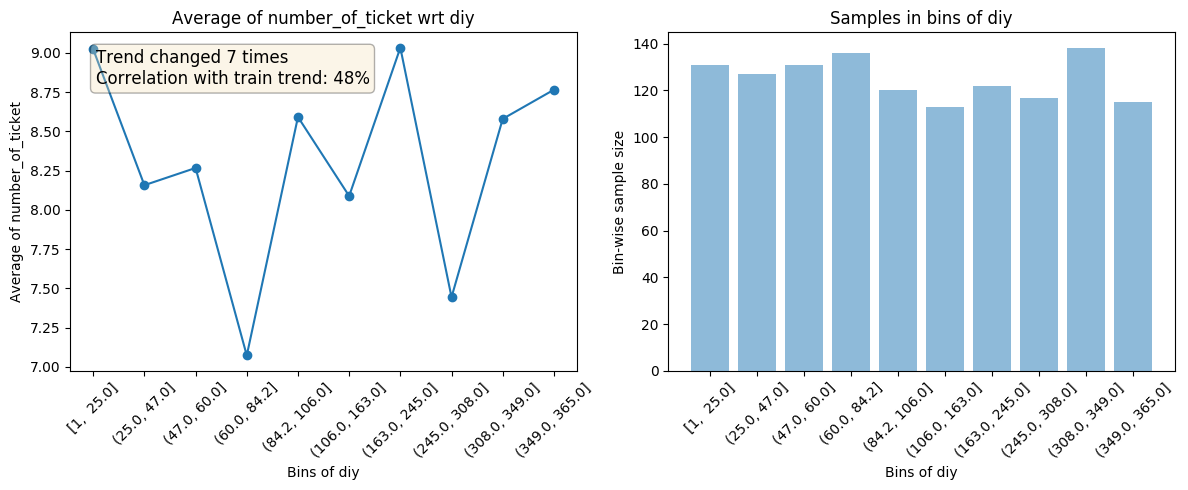

--------------------------------------------------------------------------------------------------------------


                                       Plots for evening lower                                        
                                           Train data plots                                           


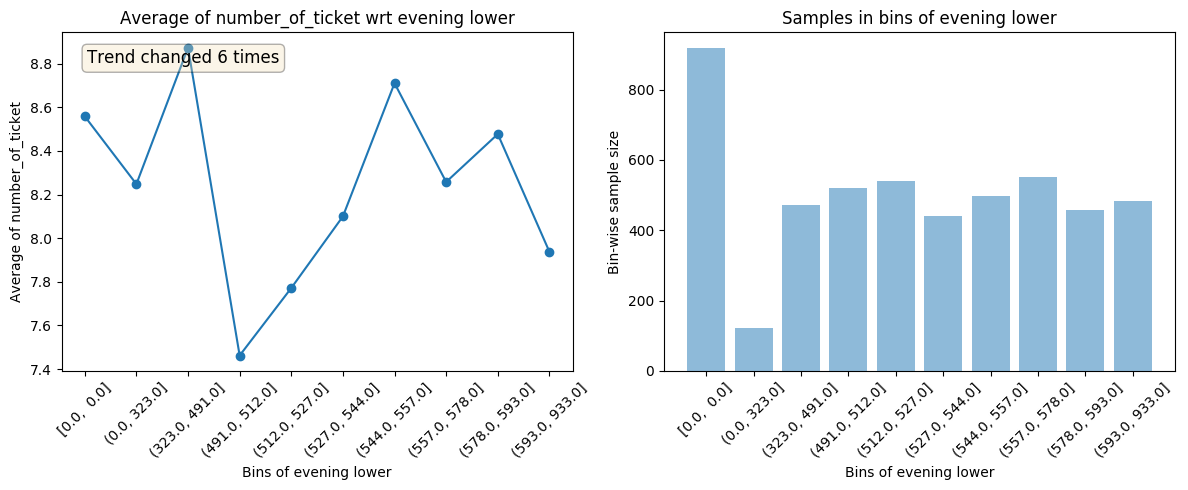

                                           Test data plots                                            


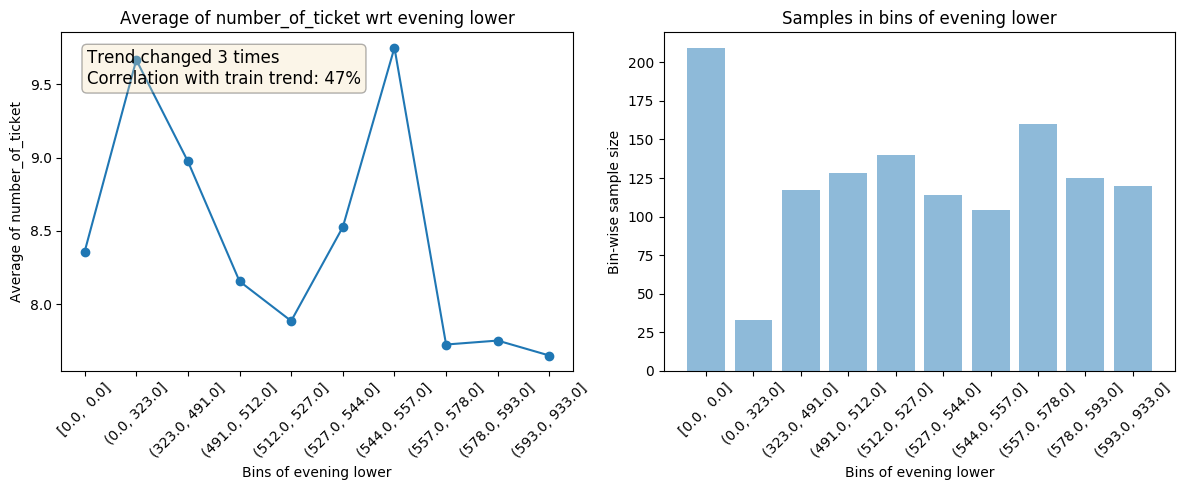

--------------------------------------------------------------------------------------------------------------


                                        Plots for max_capacity                                        
                                           Train data plots                                           


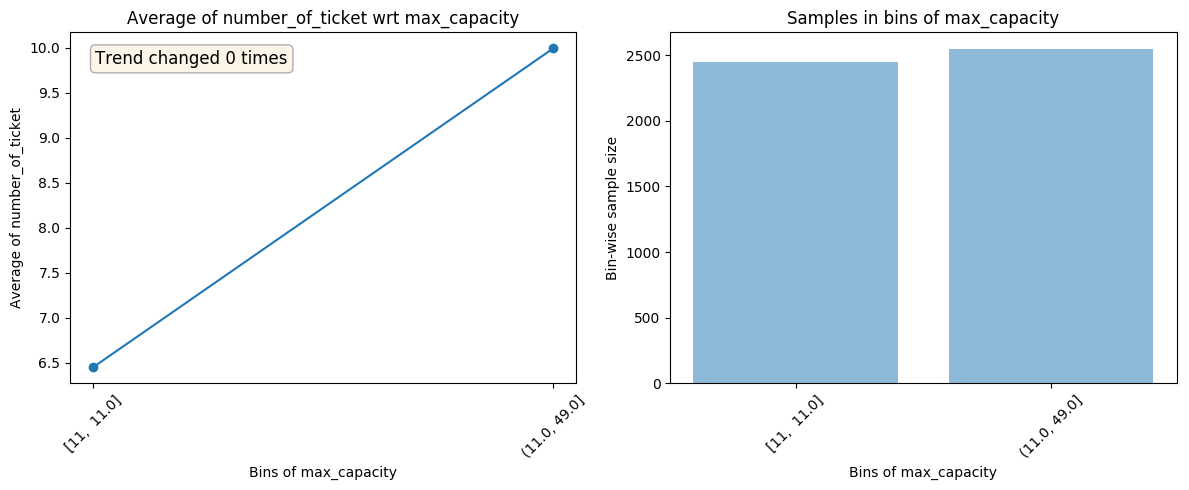

                                           Test data plots                                            


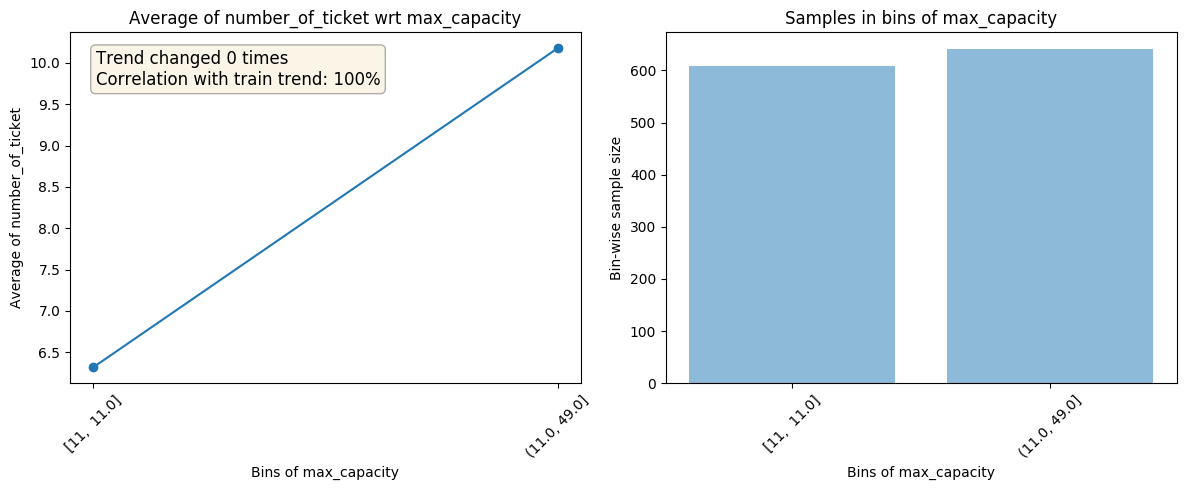

--------------------------------------------------------------------------------------------------------------


                                        Plots for midday lower                                        
                                           Train data plots                                           


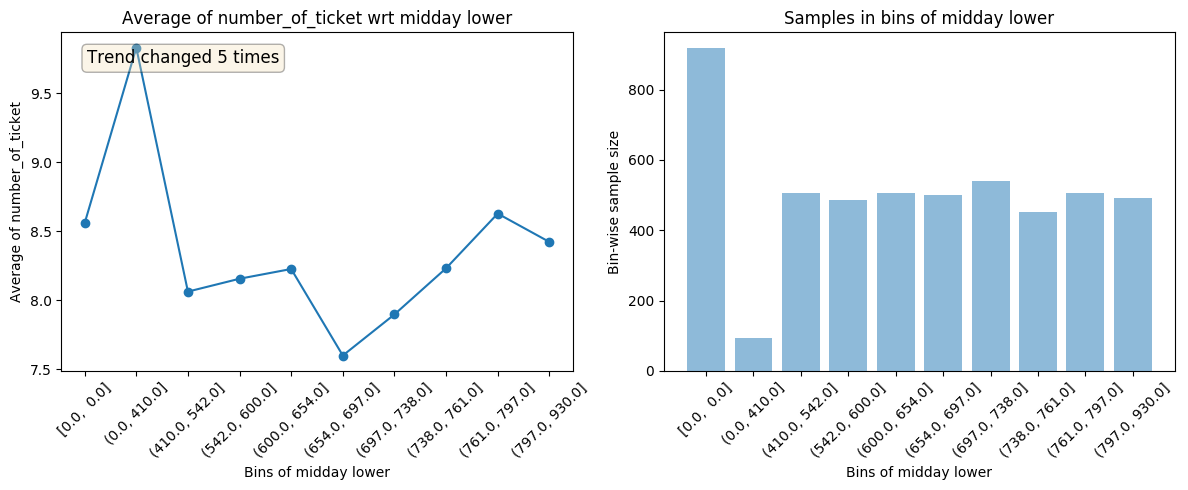

                                           Test data plots                                            


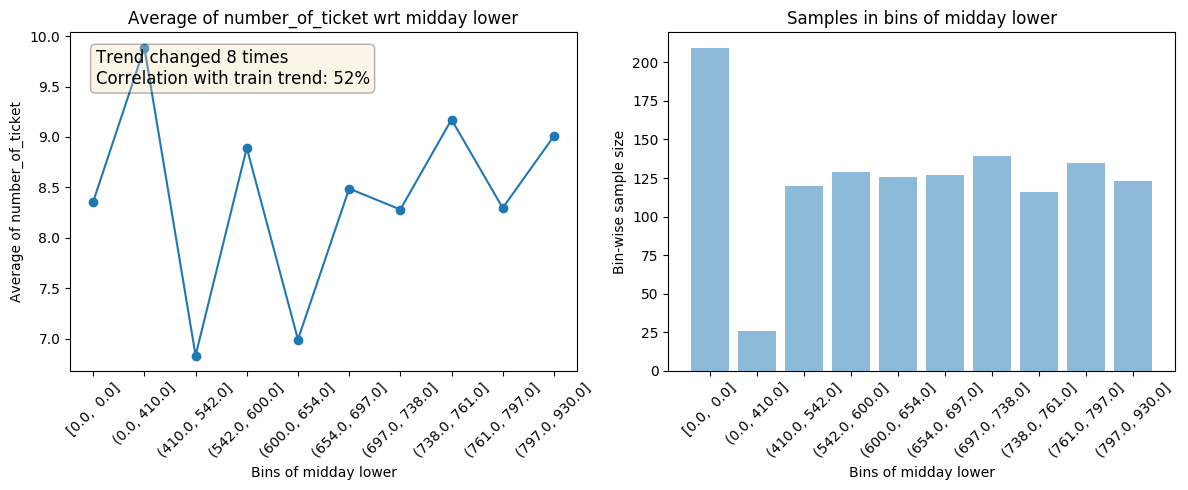

--------------------------------------------------------------------------------------------------------------


                                        Plots for travel_from                                         
                                           Train data plots                                           


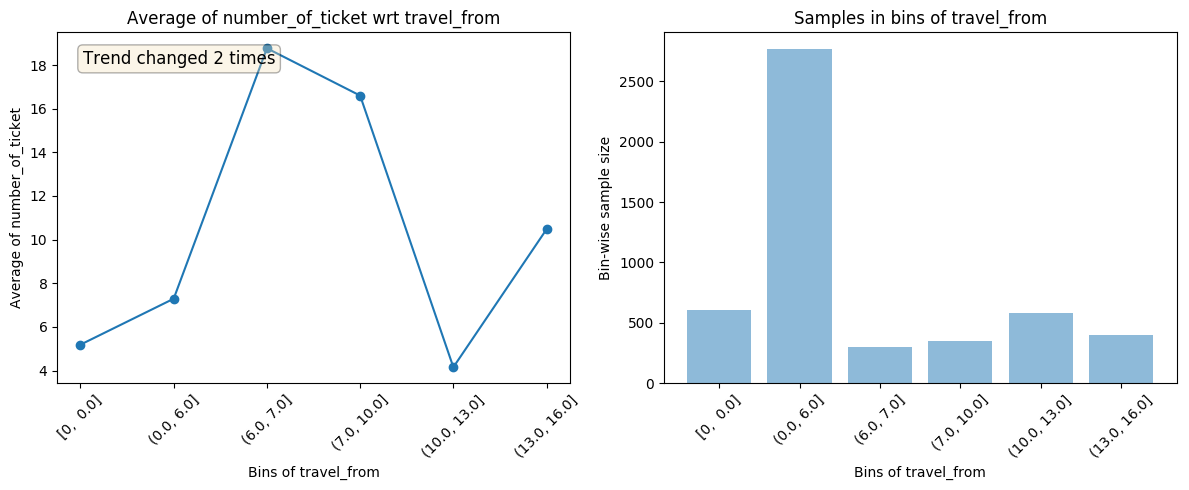

                                           Test data plots                                            


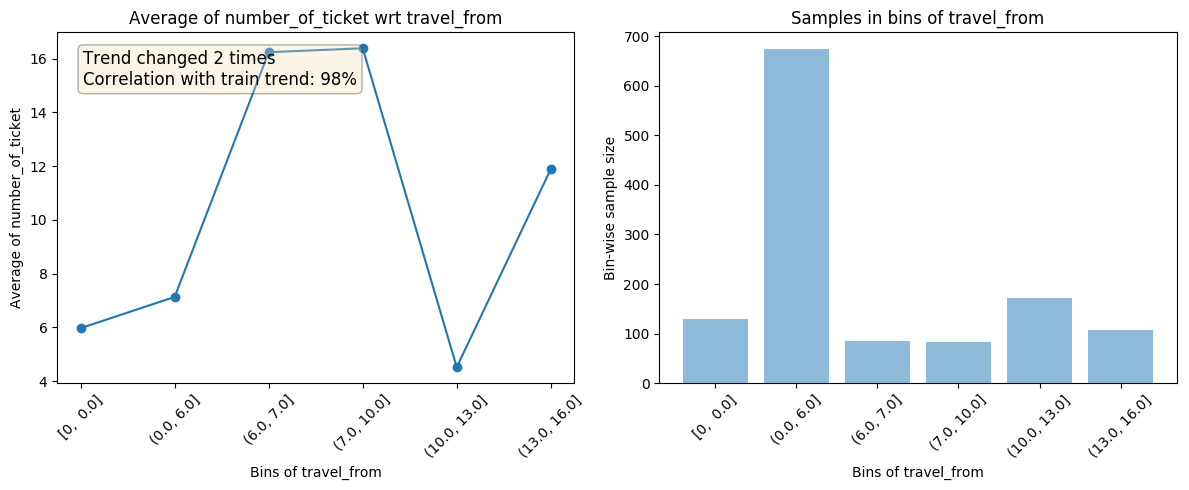

--------------------------------------------------------------------------------------------------------------


                                      Plots for travel_from_hour                                      
                                           Train data plots                                           


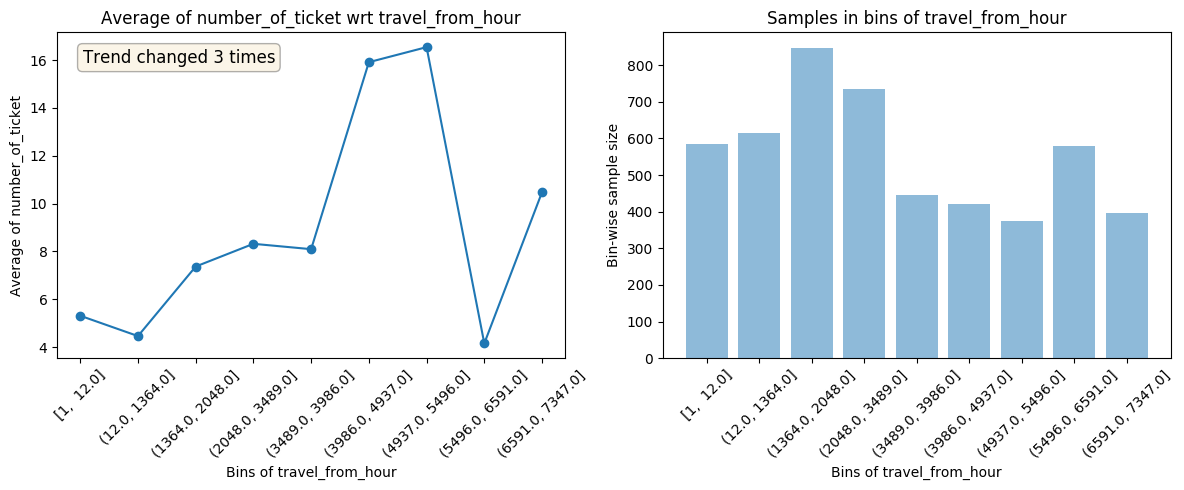

                                           Test data plots                                            


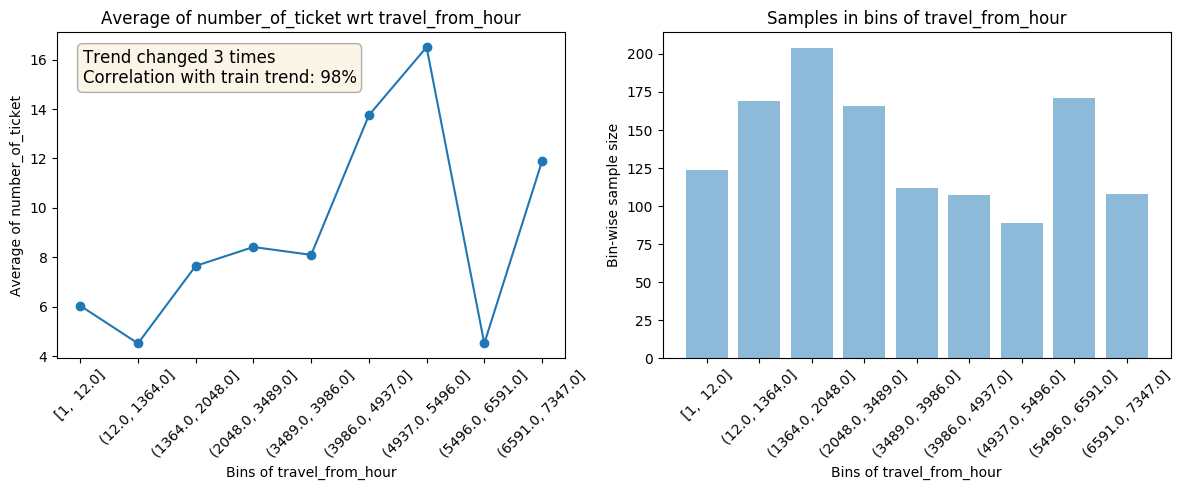

--------------------------------------------------------------------------------------------------------------


                                      Plots for travel_from_wd_h                                      
                                           Train data plots                                           


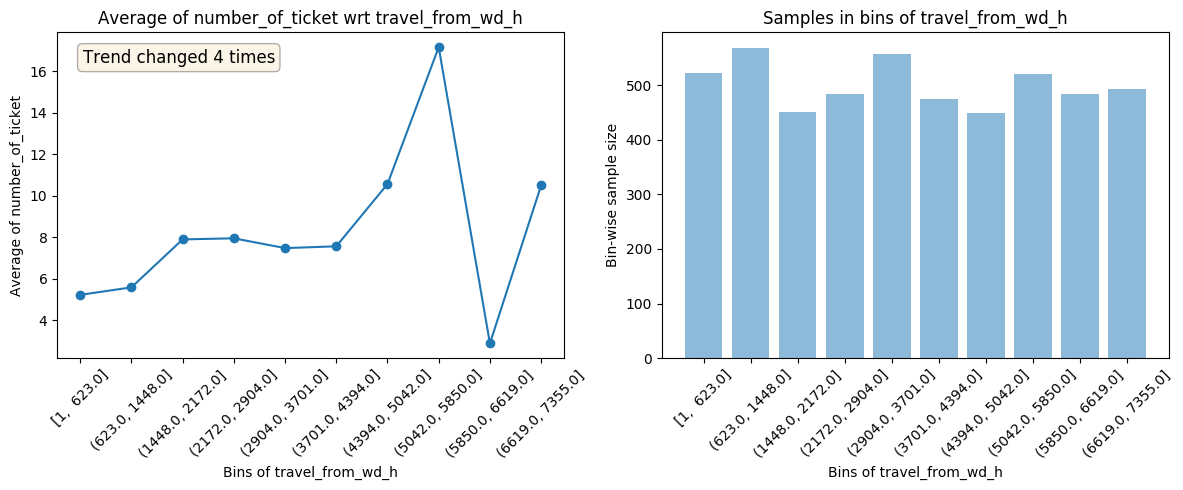

                                           Test data plots                                            


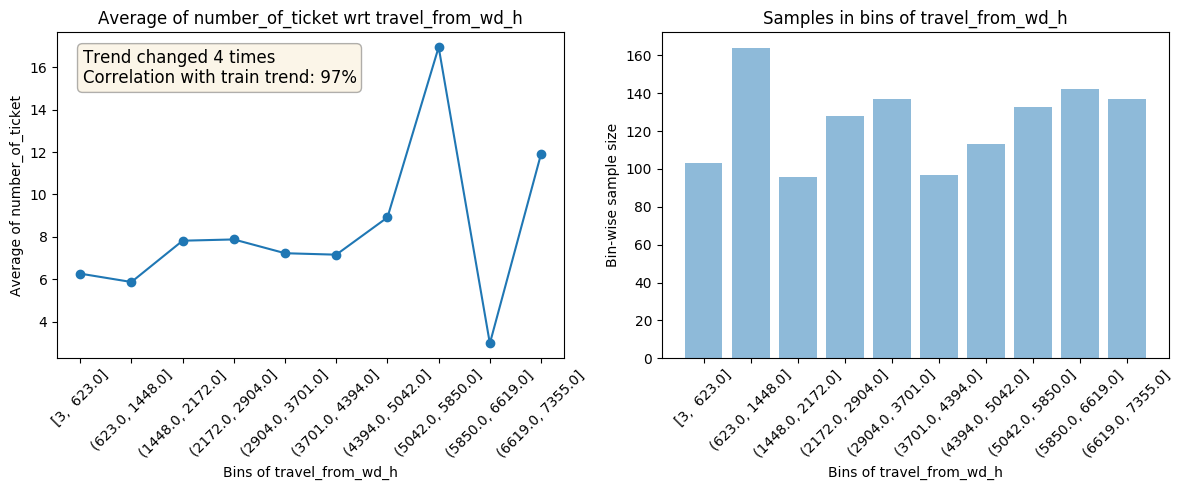

--------------------------------------------------------------------------------------------------------------


                                        Plots for travel_time                                         
                                           Train data plots                                           


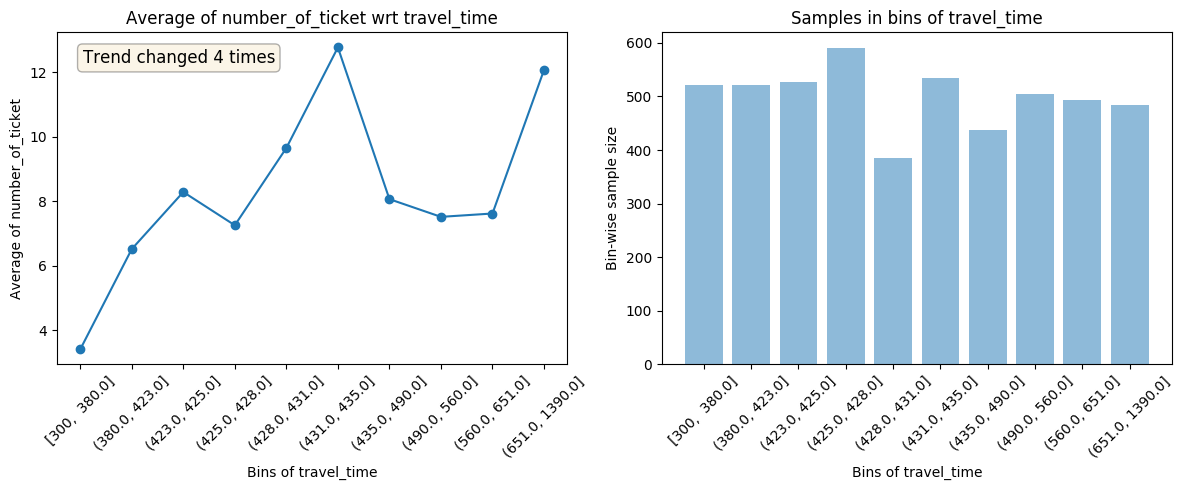

                                           Test data plots                                            


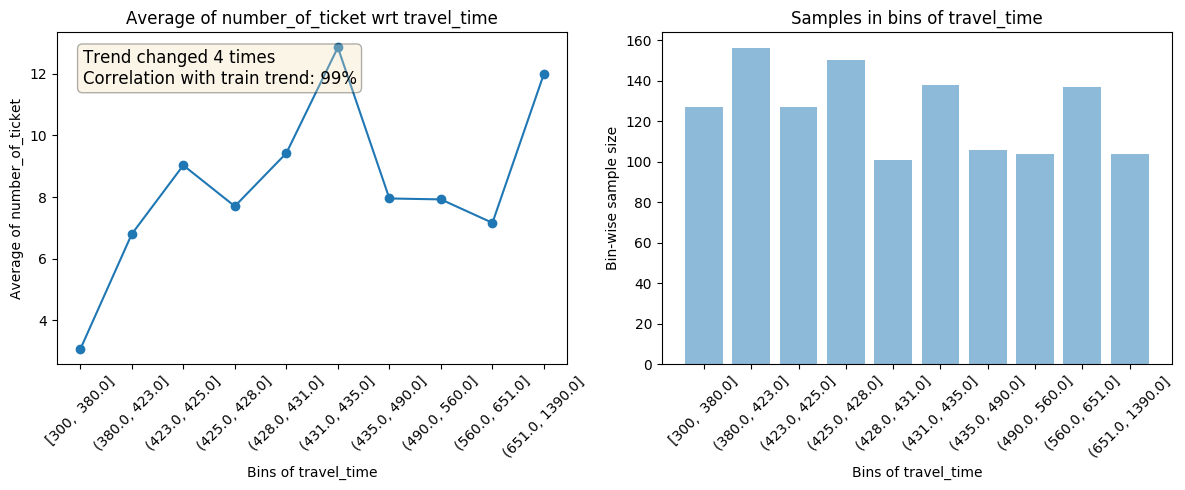

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday                                           
                                           Train data plots                                           


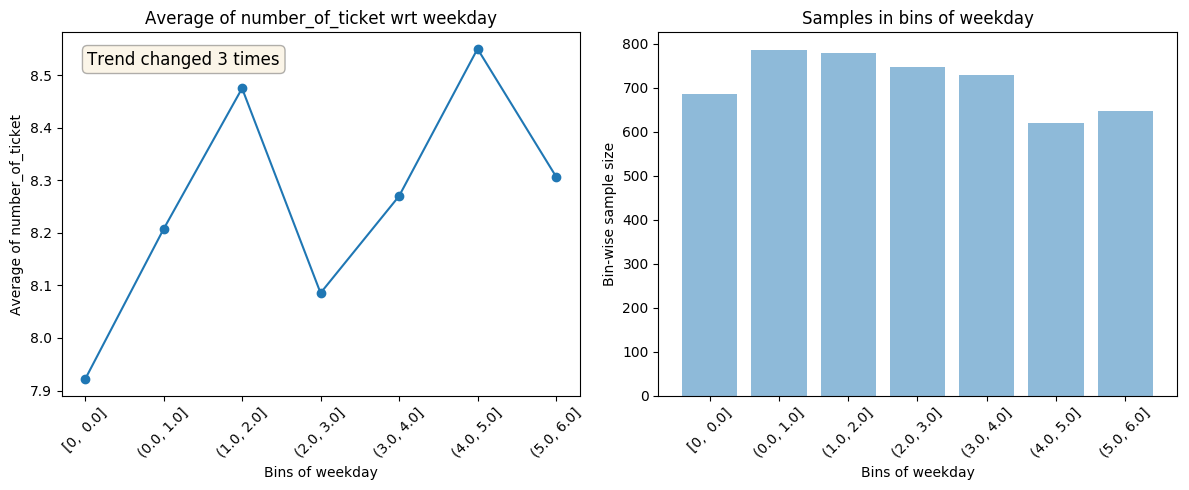

                                           Test data plots                                            


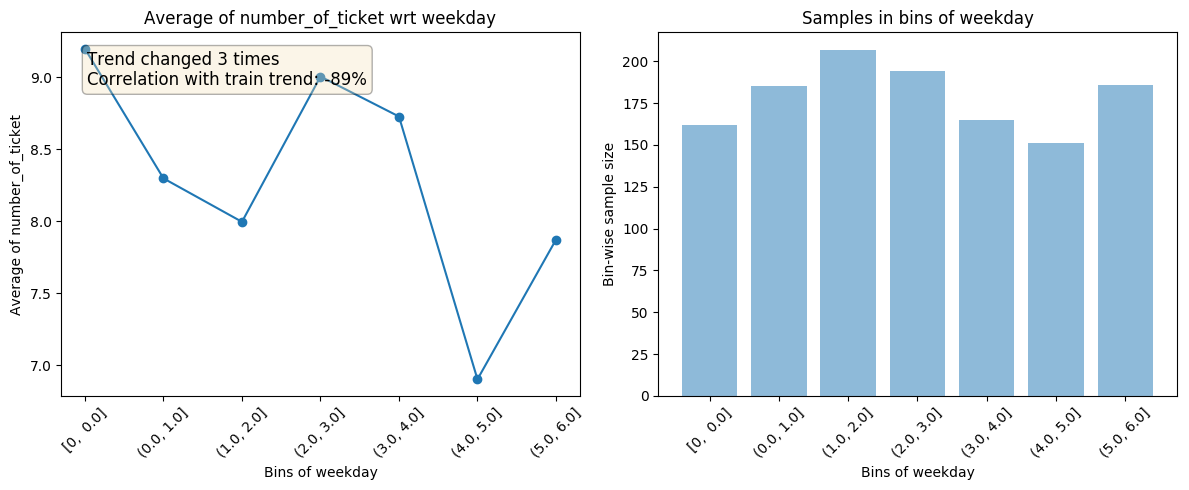

--------------------------------------------------------------------------------------------------------------




In [449]:
# Noisiness/ trend correlation
get_trend_stats(data=Xy_train, target_col='number_of_ticket', data_test=Xy_test)
get_univariate_plots(data=Xy_train, target_col='number_of_ticket', data_test=Xy_test, features_list=X_train.columns.values.tolist())

## Feature Selector
We applied the Feature Selector skript, on the dataset to see which features it would suggest for cut-back. <br/>
Script can be found [here](https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Usage.ipynb).<br/>
We found this a helpful tool for feature elimination, maybe even more useful for very feature-rich datasets (with features in the hundrets...).

In [106]:
fs = FeatureSelector(data=X_train, labels=y_train)
fs.identify_collinear(correlation_threshold=0.975)
fs.ops['collinear']
#fs.plot_collinear(plot_all=True)
fs.record_collinear

0 features with a correlation magnitude greater than 0.97.



[]

,drop_feature,corr_feature,corr_value


In [107]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'mae'
    ,n_iterations = 10, early_stopping = True)
fs.ops['zero_importance']
#fs.plot_feature_importances(threshold = 0.99, plot_n = 12)
fs.feature_importances

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[256]	valid_0's l1: 3.49677	valid_0's l2: 28.6264
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	valid_0's l1: 3.65312	valid_0's l2: 33.192
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's l1: 3.39686	valid_0's l2: 29.2404
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l1: 3.7088	valid_0's l2: 29.7161
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l1: 3.77583	valid_0's l2: 31.9879
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[252]	valid_0's l1: 3.4058	valid_0's l2: 26.5359
Training until validation scores don't improve for 100 rounds.
Early stopping, best

[]

,feature,importance,normalized_importance,cumulative_importance
0,travel_time,1184.9,0.208316,0.208316
1,diy,1061.6,0.186639,0.394954
2,travel_from_wd_h,801.4,0.140893,0.535847
3,midday lower,584.3,0.102725,0.638572
4,evening lower,566.7,0.099631,0.738203
5,travel_from_mean,362.7,0.063766,0.801969
6,travel_from_hour,320.2,0.056294,0.858263
7,month_mean,248.7,0.043724,0.901987
8,weekday_mean,145.5,0.025580,0.927567
9,weekday,137.6,0.024191,0.951758


In [82]:
fs.identify_low_importance(cumulative_importance = 0.99)
fs.ops['low_importance']

11 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.



['max_capacity_mean']

## AutoML
We tried out the auto ML tool TPOT, started off from here:<br/>
https://epistasislab.github.io/tpot/examples/#boston-housing-prices-modeling<p/>

We let TPOT run overnight and inspected and evaluated the resulting model. It suggested a stacked ensable with RandomForestRegressors and 1 GradientBoostingRegressor as a blender. THe model gave an excellent cv score, but was bad in the submitted results. It had strongly overfittet. Since we did not know how to "tune down" the overfitting, we put this model to the side.

In [ ]:
tpot = TPOTRegressor(scoring='neg_mean_absolute_error', n_jobs=-1, max_time_mins=8*60
                     , random_state=seed, memory='auto', use_dask=True, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_nairobi_pipeline.py')

In [38]:
# Average CV score on the training set was:-3.1709310176786905
pipe = make_pipeline(
    OneHotEncoder(minimum_fraction=0.25, sparse=False, threshold=10),
    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.7000000000000001
            , min_samples_leaf=1, min_samples_split=15, n_estimators=100, criterion='mae', max_depth=7)),
    SelectPercentile(score_func=f_regression, percentile=78),
    GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="lad", max_depth=7, max_features=0.45
            , min_samples_leaf=6, min_samples_split=20, n_estimators=100, subsample=1.0)
)

pipe.fit(X_train.values, y_train.values)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
print(mae)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=[False, False, True, True, False, False, False, False, False, False, True, True],
       dtype=<class 'float'>, minimum_fraction=0.25, sparse=False,
       threshold=10)), ('stackingestimator', StackingEstimator(estimator=RandomForestRegres...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

3.4334086881311507


## Notetaking of Results

We noted down all experiment results in a table in this markdown cell in Jupiter Notebook.<br/>
In hinside a better approach would have been a text file in the same directory. Having the results table in this cell led to a lot of unneccassary scrolling back and fourth in this notebook.


| Experiment | MAE | Mean | Std | Score |
|---|---|---|---|---|
| Ink ride_id | 3.73 | &#xfeff; | &#xfeff; | 5.82 |
| Ex ride_id  | 3.97 | &#xfeff; | &#xfeff; | 5.4 |
| Ex ride_id in period | 3.8 | &#xfeff; | &#xfeff; | 5.73 |
| Forest(mse) | 3.42 | 4.35 | 0.5 | &#xfeff; |
| Forest(mae) | 3.47 | 4.28 | 0.46 | &#xfeff; |
| Tree X sub | &#xfeff; | &#xfeff; | &#xfeff; | 4.04 |
| Tree X Rounded sub | &#xfeff; | &#xfeff; | &#xfeff; | 4.04 |
| Tree tuned | 3.99 | 4.22 | 0.24 | 3.89 |
| Tree cat tuned963 | 3.96 | 4.36 | 0.20 | &#xfeff; |
| Forest tuned596200 | 3.49 | 4.35 | 0.26 | &#xfeff; |
| mae | &#xfeff; | &#xfeff; | &#xfeff; | &#xfeff; |
| Tree753 | 3.95 | 3.98 | 0.4 | &#xfeff; |
| Tree773 | 3.91 | 4.01 | 0.43 | &#xfeff; |
| Tree754Cat | 4.01 | 4.01 | 0.495 | 4.16 |
| Tree773Cat | 3.69 | 4.38 | 0.454 | &#xfeff; |
| Tree772CatCh | 3.77 | 4.14 | 0.536 | &#xfeff; |
| med random | 3.88 | 4.26 | 0.45 | &#xfeff; |
| TPot 130 | 3.24 | 4.51 | 0.35 | 5.01 |
| TPoT Chr9 | 3.29 | 4.19 | 0.31 | 4.73 |
| TPoT Chr7 | 3.30 | 4.14 | 0.34 | 4.75 |
| Tree772 med alle uber cols attached til offset date, NAN0 | 3.88 | 5.54 | 0.41 | - |
| Tree772 med alle uber cols attached til offset date, NAN interpolated |4.40 | 5.56 | 0.40 | - |
| Tree772 med 2 uber cols attached til offset date, NAN0 | 4.04 | 5.49 | 0.28 | 5.47 |
| Tree772 uten uber til sammenlikning | 3.90 | 5.14 | 0.49 | 5.8 |
| Tree772 med 2 uber cols attached til travel date, NAN0 | 4.11 | 5.55 | 0.54 | - |
| Tree772 2 uber attached på offset date, NAN0 | 4.43 | 5.47 | 0.39 | 5.31 |
| " NAN-999 | 4.43 | 5.48 | 0.39 | - |
| CatBoost noisiness midday mean 0.14 evening mean 0.48| 4.65 | 4.76 | 0.71 | - |
| CatBoost Nan=Min | 4.65 | 4.76 | 0.71 | - |
| CatBoost Nan=Max | 4.66 | - | - | - |
| CatBoost catFeat Nan=0 | 4.57 | 4.77 | 0.72 | - |
| Tree794 | 3.80 | 4.11 | 0.39 | 4.05 |
| Tree794 uten hour | 3.82 | 4.08 | 0.34 | 4.03 |
| Tree794 uten hour med travel_from_hour | 3.83 | 4.05 | 0.40 | 4.02 |
| Tree762 uten hour med travel_from_hour | 4.1 | 4.05 | 0.45 | 4.5 |
| Tree794 med travel_date_ord | 3.86 | 4.04 | 0.43 | 4.05 |
| Tree795 med travel_date_ord | 3.816 | 4.0 | 0.42 | 4.037 |
| Tree795(rmse) uten travel_date_ord | 3.99 | 4.11 | 0.21 | 4.66 |
| Tree794 med doy | 3.91| 4.01 | 0.34 | 3.99|
| Tree794 med day-of-halv-year | 3.72 | 4.02 | 0.37 | 4.10 |
| Tree794 doy uten month | 3.9 | 4.05 | 0.40 | - |
| Tree6103 doy uten month | 3.83 | 4.01 | 0.46 | 4.16 |
| Tree793 med doy og moth | 3.78 | 4.06 | 0.42 | 3.98 |
| Tree793 uten car_type | 3.91 | 4.04 | 0.40 | 4.05 |
| Tree873 uten car_type | 3.86 | 4.07 | 0.29 | 4.26 |
| Tree873 uten max_capacity | 3.69 | 4.00 | 0.30 | 4.1 |
| Tree793 uten max_capacity | 3.8 | 4.09 | 0.39 | 4.06 |
| Tree782 uten max_capacity | 3.78 | 4.05 | 0.46 | - |
| Tree793 attached 6.5 | 3.79 | 4.06 | 0.42 | 3.98 |
| Tree793 uten uber null rows | 3.66 | 4.12 | 0.33 | 4.20 |
| Tree764 uten uber null rows (opt) | 3.67 | 4.12 | 0.3 | 4.39 |
| Tree793 uten test period | 3.79 | 4.06 | 0.42 | - |
| Tree984 med rainfall og holidays | 4.06 | 4.22 | 0.38 | 4.13 |
| Tree8186 med alle uber features | 3.84 | 4.1 | 0.35 | 4.14 |
| Tree793 byttet midday mean med midday lower | 3.81 | 4.07 | 0.39 | - |
| Tree7107 byttet midday mean med midday lower | 3.85 | 4.03 | 0.33 | 3.96 |
| Tree7107 med pm lower | 3.86 | 4.06 | 0.36 | - |
| Tree7117 med pm lower | 3.87 | 3.99 | 0.4 | 4 |
| Forest unoptimized med pm lower| 3.71 | 4.32 | 0.32 | - |
| Tree7117 med rank(travel_from_hour) | 3.85 | 4.08 | 0.42 | - |
| Forest910200 | 3.59 | 3.87 | 0.26 | 3.80 |
| Tree7107 med lower/mean/upper| 3.85 | 4.08 | 0.42 | - |
| Tree7117 med lower | 3.79 | 4.07 | 0.41 | - |
| Tree898 med upper | 3.92 | 4.14 | 0.48 | - |
| Tree7117 med upper | 3.79 | 4.13 | 0.44 | - |
| Tree7107 med upper | 3.77 | 4.02 | 0.36 | 4.13 |
| Tree7107 med upper (westland); feta.imp 0.026 | 3.93 | 4.13 | 0.53 | - |
| Tree7107 " joined 9.30; feta.imp 0.022| 3.82 | 4.14 | 0.43 | - |
| Tree7107 " joined 10.30; feta.imp 0.030| 3.84 | 4.09 | 0.48 | - |
| Tree7107 " joined 11; feta.imp 0.025 | 3.79 | 4.13 | 0.48 | - |
| Tree797 med mean og am mean | 3.86 | 4.15 | 0.51 | - |
| Forest910200 med mean og am mean | 3.6 | 3.9 | 0.26 | - |
| Forest88200 med mean og am mean | 3.61 | 3.87 | 0.27 | - |
| Tree797 med pm lower  | 3.74 | 4.07 | 0.53 | - |
| Tree7107 med pm lower | 3.76 | 4.07 | 0.47 | - |
| Forest910200 med pm lower | 3.58 | 3.85 | 0.28 | - |
| " mean | 3.61 | 3.88 | 0.28 | - |
| Tree7107 med mean | 3.84 | 4.14 | 0.43 | - |
| " joined 10 | 3.84 | 4.11 | 0.45 | - |
| Tree7107 HingaRd joined 8,5 midday lower | 3.82 | 4.06 | 0.47 | - |
| Tree7107 midday lower + evening lower | 3.85 | 4.08 | 0.42 | - |
| Forest910200 midday lower + evening lower | 3.59 | 3.87 | 0.26 | - |
| Forest910200 midday lower + evening lower seed 3 | 3.61 | 3.87 | 0.27 | 3.78 |
| Tree7107 midday lower + evening lower | 3.85 | 4.08 | 0.42 | - |
| Tree7107 # log(uber) | 3.85 | 4.08 | 0.42 | - |
| Forest910200 log(uber) | 3.61 | 3.87 | 0.27 | - |
| Forest88200 log(uber) |  3.62 | 3.85 | 0.27 | 3.868 |
| Tree7107 with PCA2 | 3.86 | 4.06 | 0.49 | - |
| Tree7108 with PCA2 | 3.83 | 4.09 | 0.54 | - |
| Forest88200 with PCA2 | 3.63 | 3.86 | 0.3 | - |
| Tree766 PCA2 inn, car_type, month, midday_lower, evening_lower ut | 3.69 | 4.03 | 0.32 | 4.00 |
| Tree787 with travel_from_wd_h (med og uten travel_from) | 3.74 | 4.01 | 0.34 | - |
| Tree787 with travel_from_h_wd (uten travel from) | 3.81 | 4.07 | 0.45 | - |
| Forest88200 med travel_from_wd_h | 3.65 | 3.88 | 0.29 | 3.85 |
| Gbm out of the gate " | 3.7 | 3.69 | 0.12 | 4.11 |
| Gbm out of the gate u. early stopping | 3.7 | 4.26 | 0.38 | 4.11 |
| Gbm75205531 opt u. eearly stopping | 3.8 | 4.16 | 0.31 | 4.17 |
| Gbm75205531 opt med eearly stopping | 3.8 | 3.77 | 0.1 | 4.17 |
| Cat | 3.86 | - | - | - |
| Gbm75205531 opt u. eearly stopping med catwgorical | 3.83 | 4.16 | 0.31 | - |
| Med mean 200 | 3.63 | 3.87 | 0.28 | 3.67 |
| 910n200 | 3.62 | 3.86 | 0.25 | 3.66591676040495 |



## Submit

In [151]:
model = forest
model.fit(X.values, y.values)
X_submit = df_quest[df_quest.columns.difference(skipcols)]
y_submit = model.predict(X_submit)
submission = df_quest[['ride_id']].copy()
submission['number_of_ticket'] = y_submit.round(0).astype(int)
submission.head()
submission.to_csv(path_or_buf='my_submission56.csv', index=False)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=9,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=3,
           verbose=0, warm_start=False)

,ride_id,number_of_ticket
6249,247,5
6250,256,8
6251,275,1
6252,285,9
6253,286,9
